<a href="https://colab.research.google.com/github/Birkity/zero_day/blob/master/ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Independent Component Analysis (ICA) from Scratch

Project Overview:
This notebook demonstrates how to implement Independent Component Analysis (ICA) from scratch using the
Wisconsin Diagnostic Breast Cancer (WDBC) dataset. The goal is to reduce dimensionality while maintaining
as much statistical independence between features as possible. ICA is particularly useful in applications
such as blind source separation (e.g., separating mixed audio signals) and feature extraction.

Why Dimensionality Reduction?
- High-dimensional data can be redundant and computationally expensive.
- Reducing dimensions improves model efficiency and interpretability.
- ICA helps extract statistically independent features, which can enhance downstream tasks like classification.

Mathematical Foundation:
ICA seeks to find a linear transformation of the data that maximizes the statistical independence of the components.
It assumes the observed data is a linear mixture of independent source signals and aims to recover these sources.


In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import FastICA
from sklearn.datasets import load_breast_cancer

In [14]:
# Load the Wisconsin Diagnostic Breast Cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [15]:
# Exploratory Data Analysis (EDA)
print("Dataset Shape:", X.shape)
print("Dataset Description:\n", data.DESCR)
print("Summary Statistics:\n", X.describe())

Dataset Shape: (569, 30)
Dataset Description:
 .. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 

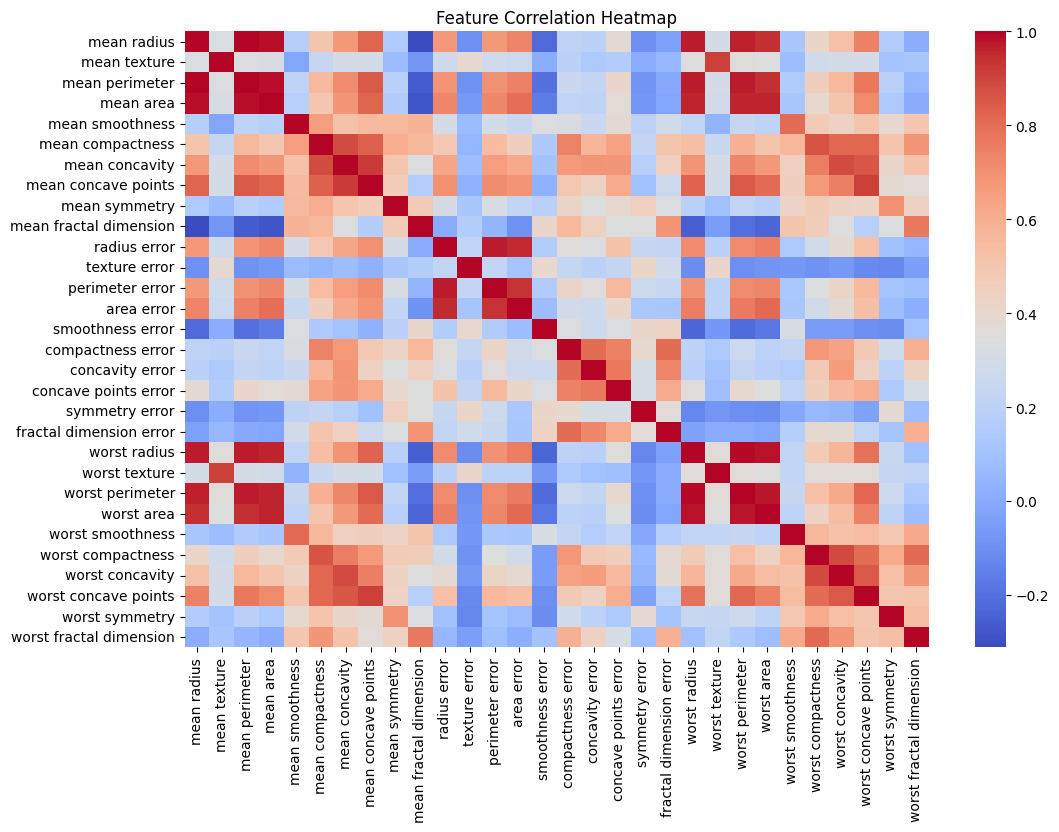

In [16]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [17]:
# Standardizing the dataset to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Logistic Regression on Original Data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model_orig = LogisticRegression(max_iter=1000)
model_orig.fit(X_train_orig, y_train_orig)
score_orig = model_orig.score(X_test_orig, y_test_orig)
print(f'Classification Accuracy using Original Features: {score_orig:.4f}')

Classification Accuracy using Original Features: 0.9737


### Function: whiten_data
--------------------
This function whitens the data, which is a crucial step in ICA.
Whitening ensures that the features are uncorrelated and have unit variance.
This is done using eigenvalue decomposition of the covariance matrix.

Steps:
1. Compute the covariance matrix of the dataset.
2. Perform eigenvalue decomposition.
3. Transform the dataset using the eigenvectors and normalize by the square root of eigenvalues.


- This function makes data easier to work with by turning it into a simple, clean form for something called Independent Component Analysis (ICA). Here's how it works, broken down into easy-to-understand steps:

- What is Covariance?
Imagine you have a bunch of numbers (like the height and weight of people). Sometimes, when one number goes up, the other does too (like taller people often weigh more). This relationship is called covariance. We calculate this for all pairs of numbers to get a "covariance matrix."

Simple Formula:
- Covariance of X and Y = Average of [(X - Average X) * (Y - Average Y)]
- Eigenvalues and Eigenvectors:
- Eigenvectors: Think of these as directions where the data stretches the most. They're like finding the main directions in which your data varies.
- Eigenvalues: These tell you how much of the stretch happens in those directions. A big eigenvalue means a lot of stretch (variation) in that direction.

Simple Explanation: If you imagine data points like a cloud of points, eigenvectors are the main axes of this cloud, and eigenvalues tell how long these axes are.
Formula:
- The covariance matrix (C) can be broken down into:
- C = V * Λ * V^T where:
- V is a matrix of eigenvectors
- Λ (lambda) is a diagonal matrix with eigenvalues on its diagonal
Whitening:
- Why Whiten?: We want each direction (feature) to be independent from each other and to have the same "size" or variance.
- How: We use the eigenvectors to rotate our data into these main directions and then scale it by the inverse square root of the eigenvalues. This makes all directions equally important (variance of 1).

Simple Formula:
- Whitened Data = V * (1/sqrt(Λ)) * V^T * Original Data

Here, sqrt(Λ) means we take the square root of each eigenvalue, and we divide by it to normalize each direction.

Relation to ICA:

- ICA: After whitening, ICA is like trying to unscramble mixed signals (like hearing two people talk at once through one speaker). It finds how to separate these signals back into their original, independent forms.

Formula for ICA (in simple terms):

After whitening, we use another matrix (W) to transform our data to get back to the original signals:
- Independent Components = W * Whitened Data


If you're dealing with different data, like images or sounds, think of:
Covariance as how much one part of an image changes when another does.
Eigenvectors as the main patterns in your data, like main colors or sounds.
Whitening as adjusting these patterns so they're all on an equal footing, making it easier to see or hear each part distinctly.

In [19]:
def whiten_data(X):
    cov_matrix = np.cov(X, rowvar=False)  # Compute covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)  # Eigenvalue decomposition
    X_whitened = np.dot(X, eigenvectors) / np.sqrt(eigenvalues + 1e-5)  # Normalize
    return X_whitened, eigenvectors

In [21]:
# Whitening the dataset
X_whitened, whitening_matrix = whiten_data(X_scaled)

Function: g
----------
This is the non-linear function used in ICA to maximize non-Gaussianity.
We use a hyperbolic tangent (tanh) function, which works well for ICA.

Mathematically:
g(u) = tanh(u)
g'(u) = 1 - tanh²(u)

Where g(u) is the derivative function used in the fixed-point iteration method.

This function helps separate mixed signals in ICA:

- g(u) = tanh(u): It stretches small changes and squashes big ones, making signals easier to tell apart.
- g'(u) = 1 - tanh²(u): Shows how fast we're changing at each point, useful for fine-tuning signal separation.

In Simple Terms:
Helps make each signal unique in a mix, like picking out voices in a crowd.

In [8]:
def g(u):
    return np.tanh(u), 1 - np.tanh(u) ** 2

Function: fast_ica
------------------
This function implements the FastICA algorithm using the fixed-point iteration method.

Steps:
1. Initialize random weights.
2. Update weights using Newton's method.
3. Orthogonalize weights to ensure independence.
4. Repeat until convergence.


### Fast Independent Component Analysis (FastICA) for signal separation:

FastICA is an efficient algorithm for performing Independent Component Analysis (ICA), which aims to separate mixed signals into their original, independent components.

Key Concepts:
- Non-Gaussianity: ICA leverages the fact that independent sources are typically non-Gaussian. FastICA maximizes this by using a non-linear function (like tanh) to push data away from Gaussianity.
- Whitening: Data should be pre-whitened to ensure features are uncorrelated and have unit variance, simplifying the problem for FastICA by reducing it to finding rotations in this space.

Algorithm Steps:
- Initialization: Start with random guesses for the unmixing matrix (weights).
Iteration:
- Update Weights: Use the fixed-point iteration (Newton's method) where the non-linear function g(u) = tanh(u) is crucial for adjusting weights towards non-Gaussian directions.
- Orthogonalization: After each update, the weights are orthogonalized to ensure the independence of the components being separated.
- Convergence: Repeat until the weights stabilize, meaning the independent components are well-identified.

Relation to Other Functions:
- g(): This function provides the non-linearity needed for the weight update in each iteration, helping to find directions where the data is least Gaussian.
- whiten_data(): Essential preprocessing step that FastICA relies on to work effectively by transforming the data into an uncorrelated space with unit variance.

Parameters:
data: Input data that has been pre-whitened, expected to be a numpy array of shape (n_samples, n_features).

Returns:
An array representing the unmixing matrix (weights) that can transform the mixed data back into independent signals.

In [22]:
def fast_ica(X, num_components, max_iter=1000, tol=1e-6):
    n_samples, n_features = X.shape
    W = np.random.randn(num_components, n_features)  # Initialize random weights

    for i in range(num_components):
        w = W[i, :].copy()

        for _ in range(max_iter):
            w_new = np.mean(X * g(np.dot(X, w))[0][:, np.newaxis], axis=0) - np.mean(g(np.dot(X, w))[1]) * w
            w_new /= np.linalg.norm(w_new)  # Normalize

            # Decorrelate (Gram-Schmidt process)
            for j in range(i):
                w_new -= np.dot(w_new, W[j]) * W[j]
            w_new /= np.linalg.norm(w_new)

            # Check for convergence
            if np.abs(np.abs(np.dot(w, w_new)) - 1) < tol:
                break
            w = w_new

        W[i, :] = w

    return np.dot(X, W.T)  # Return the independent components

In [23]:
# Applying ICA on the dataset
num_components = 20  # Reduce to 20 independent components
X_ica = fast_ica(X_whitened, num_components)

In [24]:
# Logistic Regression on ICA-reduced Data
X_train, X_test, y_train, y_test = train_test_split(X_ica, y, test_size=0.2, random_state=42)
model_ica = LogisticRegression(max_iter=1000)
model_ica.fit(X_train, y_train)
score_ica = model_ica.score(X_test, y_test)
print(f'Classification Accuracy using ICA-reduced Features: {score_ica:.4f}')

Classification Accuracy using ICA-reduced Features: 0.7719


Visualization: Plot independent components
-------------------------------------------
This visualization shows the extracted independent components as feature distributions.
Since ICA focuses on maximizing statistical independence, these components capture unique structures.


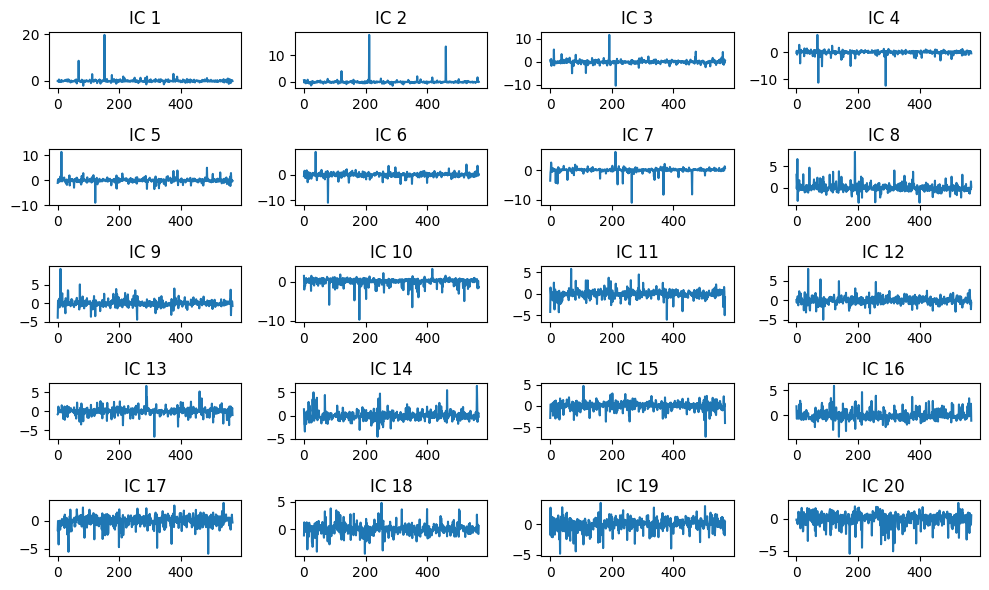

In [26]:
plt.figure(figsize=(10, 6))
for i in range(num_components):
    plt.subplot(num_components // 4, 4, i+1)
    plt.plot(X_ica[:, i])
    plt.title(f'IC {i+1}')
plt.tight_layout()
plt.show()

Classification: Logistic Regression
-----------------------------------
We now use the extracted ICA components for classification to see how well they retain information.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_ica, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f'Classification Accuracy using ICA: {score:.4f}')

Classification Accuracy using ICA: 0.6316
